In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import os
import torch
from collections import defaultdict

torch.manual_seed(0)


## Data Loading and EDA

In [2]:
path = 'PADUFES'
metadata = pd.read_csv(f'{path}/metadata.csv')
metadata.dtypes

patient_id              object
lesion_id                int64
smoke                   object
drink                   object
background_father       object
background_mother       object
age                      int64
pesticide               object
gender                  object
skin_cancer_history     object
cancer_history          object
has_piped_water         object
has_sewage_system       object
fitspatrick            float64
region                  object
diameter_1             float64
diameter_2             float64
diagnostic              object
itch                    object
grew                    object
hurt                    object
changed                 object
bleed                   object
elevation               object
img_id                  object
biopsed                   bool
dtype: object

In [3]:
# Retain only FST labelled images in imgs_part_1

metadata_processed = metadata[~metadata['fitspatrick'].isna()]
metadata_processed = metadata_processed[['img_id', 'fitspatrick','diagnostic']]

images = f'{path}/imgs_part_1'
metadata_processed = metadata_processed[metadata_processed['img_id'].isin(os.listdir(images))]



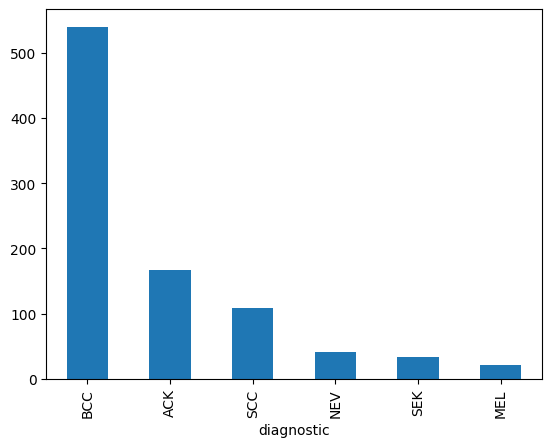

In [4]:
# Visualise fst and diagnostic distribution
metadata_processed['diagnostic'].value_counts().plot(kind='bar')
plt.show()

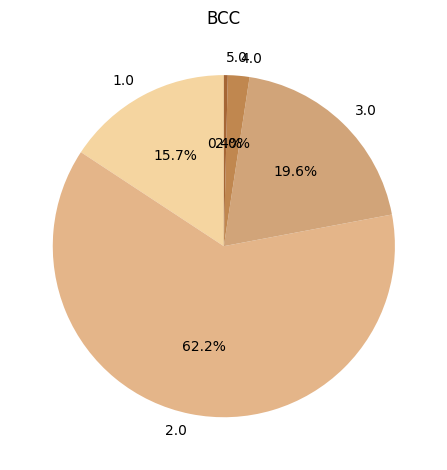

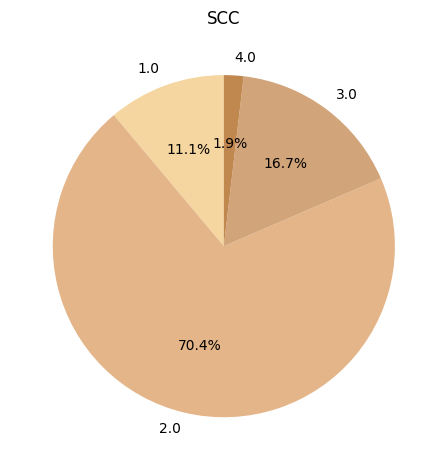

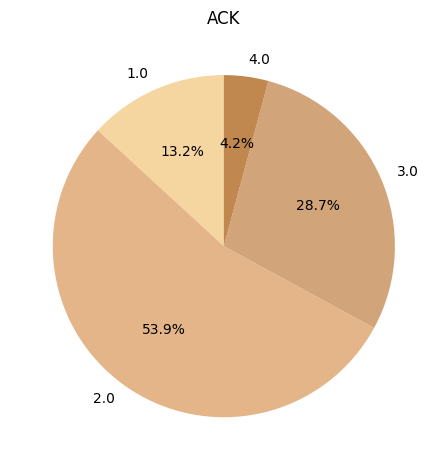

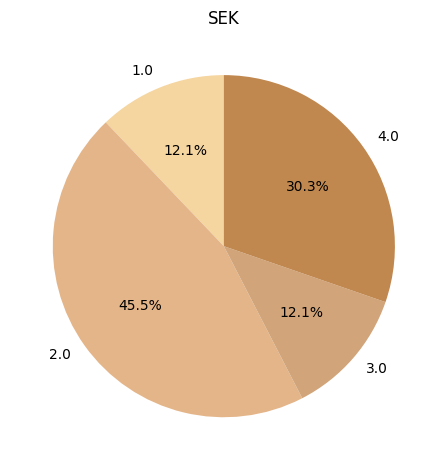

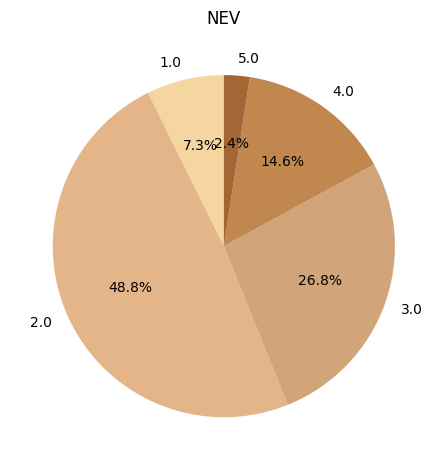

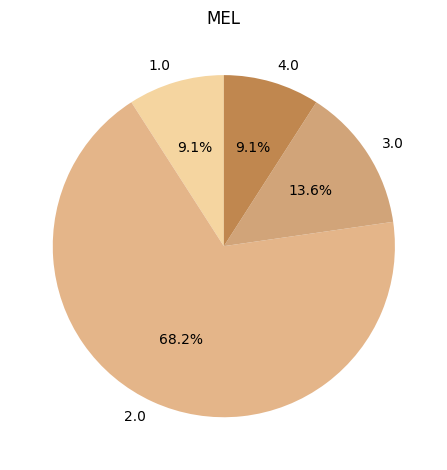

In [107]:
fst_color_map = {
    1: '#F5D5A0',
    2: '#E4B589',
    3: '#D1A479',
    4: '#C0874F',
    5: '#A56635',
    6: '#4C2C27'
}

for condition in metadata_processed['diagnostic'].unique():
    
    counts = metadata_processed[metadata_processed['diagnostic'] == condition]['fitspatrick'].value_counts().sort_index()

    colors = [fst_color_map[fst] for fst in counts.index]

    counts.plot(kind='pie', colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(condition)
    plt.ylabel('')  
    plt.tight_layout()
    plt.show()


## Create Dataset

Resample metadata for balanced sample size of conditions

In [83]:
def subsample_metadata(pd_metadata, target_conditions=['BCC', 'ACK', 'SCC'], samples_per_condition=None):

    filtered_metadata = pd_metadata[pd_metadata['diagnostic'].isin(target_conditions)].copy()

    if samples_per_condition is None:
        condition_counts = filtered_metadata['diagnostic'].value_counts()
        samples_per_condition = condition_counts.min()

    balanced_dfs = []
    
    for condition in target_conditions:
        condition_data = filtered_metadata[filtered_metadata['diagnostic'] == condition]
        
        if len(condition_data) >= samples_per_condition:
            # Randomly sample if we have enough data
            sampled_data = resample(condition_data, 
                                  n_samples=samples_per_condition, 
                                  random_state=42, 
                                  replace=False)
        else:
            sampled_data = condition_data
        
        balanced_dfs.append(sampled_data)
    
    balanced_metadata = pd.concat(balanced_dfs, ignore_index=True)

    balanced_metadata = balanced_metadata.sample(frac=1, random_state=42).reset_index(drop=True)
    

    return balanced_metadata


In [84]:
metadata_processed = subsample_metadata(metadata_processed, target_conditions=['BCC', 'ACK', 'SCC'])

Create dataset class and transformations

In [5]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomAffine(degrees=10, shear= (-10,10,-10,10)),
])

In [6]:
class PADUFESDataset(Dataset):
    def __init__(self, pd_metadata, images_dir, transform=transformations, diagnostic_encoder=None):
        """
        Args:
            pd_metadata (pd DataFrame): metadata dataframe.
            images_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.metadata = pd_metadata
        self.images_dir = images_dir
        self.transform = transform

        self.img_ids = self.metadata['img_id'].values
        self.fst_labels = self.metadata['fitspatrick'].values  
        self.condition = self.metadata['diagnostic'].values
        if diagnostic_encoder is None:
            self.diagnose_encoder = OneHotEncoder()
            self.diagnostic = self.diagnose_encoder.fit_transform(self.metadata['diagnostic'].values.reshape(-1, 1)).toarray()  

        else:
            self.diagnose_encoder = diagnostic_encoder
            self.diagnostic = self.diagnose_encoder.transform(self.metadata['diagnostic'].values.reshape(-1, 1)).toarray()
            
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = f"{self.img_ids[idx]}"  
        img_path = os.path.join(self.images_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='white')
        
        if self.transform:
            image = self.transform(image)
        
        
        fst = torch.tensor(self.fst_labels[idx], dtype=torch.float)
        diagnosis = torch.tensor(self.diagnostic[idx], dtype=torch.float)
        
        sample = {
            'image': image,
            'img_id': self.img_ids[idx],
            'fst': fst,
            'diagnosis': diagnosis,
            'condition': self.condition[idx]
        }
        
        return sample



Create train and test datasets and dataloaders

In [7]:
metadata_train, metadata_test = train_test_split(metadata_processed, test_size=0.2, random_state=42)

PAD_train = PADUFESDataset(metadata_train, images)  
PAD_test = PADUFESDataset(metadata_test, images, diagnostic_encoder=PAD_train.diagnose_encoder)


In [8]:
conditions_mapping = PAD_train.diagnose_encoder.categories_[0]
conditions_mapping

array(['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK'], dtype=object)

In [9]:
pad_train_dataloader = torch.utils.data.DataLoader(
    PAD_train,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

pad_test_dataloader = torch.utils.data.DataLoader(
    PAD_test,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

## Create Model

In [10]:
model = models.resnet50(weights='IMAGENET1K_V1')

In [114]:
for name, param in model.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [11]:
num_classes = 6
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, num_classes),
    torch.nn.Softmax(dim=1)
)

for name, param in model.named_parameters():
    param.requires_grad = True
    if 'fc' not in name:
        continue
        #param.requires_grad = False

## Train, Evaluation and Metrics Functions

### Training Function

In [ ]:
def train_model(model, dataloader, num_epochs=5, learning_rate=0.001, use_wandb=False):

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if use_wandb:
        import wandb

        config={
            
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "loss": criterion,
            "optimizer": optimizer
        
        }
        wandb.login()
        wandb.init(project="PADUFES_Training", config=config, name='training_run')
        wandb.watch(model, log="all")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['diagnosis'].to(device) 
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

    wandb.finish()


### Across condition metrics

In [13]:
def top_k_accuracy(labels, outputs, k=1):
    '''Returns the top k accuracy of model '''

    true_diagnosis = labels.argmax(dim=1)
    ordered_k_outputs = outputs.argsort(dim=1, descending=True)[:, :k]  

    correct = (true_diagnosis[:, None] == ordered_k_outputs).any(dim=1)
    
    return correct.sum().float() 

def top_k_senstivity(labels, outputs, k=1):
    '''Returns the top k accuracy for each condition'''

    true_diagnosis = labels.argmax(dim=1)
    
    sensitivities = {}

    for condition in true_diagnosis.unique():
        condition_indices = (true_diagnosis == condition).nonzero(as_tuple=True)[0]
        if len(condition_indices) == 0:
            continue
        
        condition_labels = labels[condition_indices]
        condition_outputs = outputs[condition_indices]
        
        correct = top_k_accuracy(condition_labels, condition_outputs, k)
        
        sensitivities[condition.item()] = correct 

    return sensitivities

def missclassfied_samples(labels, outputs, ids):
    true_diagnosis = labels.argmax(dim=1)
    predicted_diagnosis = outputs.argsort(dim=1, descending=True)

    sample_ids = []

    for i in range(len(true_diagnosis)):
        if true_diagnosis[i] not in predicted_diagnosis[i, 0:3]:
            sample_ids.append(ids[i])
    
    return sample_ids

### Across FST metrics

In [14]:
def stratified_top_k_accuracy(labels, outputs, fst, k=1):
    '''Returns the top k accuracy stratified by skin tone (FST)'''

    stratified_accuracy = defaultdict(int)
    
    for skintone in fst.unique():
        skintone_indices = (fst == skintone).nonzero(as_tuple=True)[0]
        if len(skintone_indices) == 0:
            continue
        fst_labels = labels[skintone_indices]
        fst_outputs = outputs[skintone_indices]

        correct = top_k_accuracy(fst_labels, fst_outputs, k)
        stratified_accuracy[skintone.item()] = correct.item()
    return stratified_accuracy

def stratified_top_k_sensitivity(labels, outputs, fst, k=1):
    stratified_sensitivity = defaultdict(lambda: defaultdict(int))
    
    for skintone in fst.unique():
        skintone_indices = (fst == skintone).nonzero(as_tuple=True)[0]
        if len(skintone_indices) == 0:
            continue
        fst_labels = labels[skintone_indices]
        true_diagnosis = fst_labels.argmax(dim=1)
        fst_outputs = outputs[skintone_indices]

        for condition in true_diagnosis.unique():
            condition_indices = (true_diagnosis == condition).nonzero(as_tuple=True)[0]
            if len(condition_indices) == 0:
                continue
            condition_labels = fst_labels[condition_indices]
            condition_outputs = fst_outputs[condition_indices]
            correct = top_k_accuracy(condition_labels, condition_outputs, k)
            stratified_sensitivity[skintone][condition] = correct.item()
    return stratified_sensitivity



### Display

In [15]:
def display_top3_sensitivity(sensitivities, conditions_mapping):
    for condition in sensitivities.keys():
        try:
            print(f"Condition: {conditions_mapping[int(condition)]}, Top-3 Sensitivity: {sensitivities[int(condition)]:.2f}%")
        except KeyError:
            print('Error: Condition not found in mapping:')

    average_sensitivity = sum(sensitivities.values()) / len(sensitivities)
    print(f"Average Top-3 Sensitivity: {average_sensitivity:.2f}%")

def display_stratified_sensitivity(sensitivities, conditions_mapping):
    for skintone, condition_sensitivities in sensitivities.items():
        print(f"Skin Tone: {skintone}")
        for condition, sensitivity in condition_sensitivities.items():
            try:
                print(f"  Condition: {conditions_mapping[int(condition)]}, Top-3 Sensitivity: {sensitivity:.2f}%")
            except KeyError:
                print('  Error: Condition not found in mapping:')
        print()

def display_stratified_accuracy(accuracy, conditions_mapping):
    for skintone, acc in accuracy.items():
        print(f"Skin Tone: {skintone}, Top-3 Accuracy: {acc:.2f}%")

In [16]:
def display_images(*img_ids):
    for img_id in img_ids:
        img_path = os.path.join(images, img_id)
        try:
            image = Image.open(img_path).convert('RGB')
            plt.imshow(image)
            plt.title(img_id)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")


### Eval function

In [17]:
def evaluate_model(model, dataloader, skin_stratified=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    
    top_3_accuracy = 0
    top_3_sensitivity = defaultdict(int)

    missclassified_samples_list = []

    condition_sample_counts = defaultdict(int)
    fst_sample_counts = defaultdict(int)
    condition_fst_counts = defaultdict(lambda: defaultdict(int))
    total_samples = 0

    if skin_stratified:
        stratified_accuracy = defaultdict(int)
        stratified_sensitivity = defaultdict(lambda: defaultdict(int))

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            ids = batch['img_id']
            labels = batch['diagnosis'].to(device) 

            # Update sample counts

            for condition in labels.argmax(dim=1).unique():
                condition_sample_counts[condition.item()] += (labels.argmax(dim=1) == condition).sum().item()

            for skintone in batch['fst'].unique():
                fst_sample_counts[skintone.item()] += (batch['fst'] == skintone).sum().item()

            for condition, skintone in zip(labels.argmax(dim=1), batch['fst']):
                condition_fst_counts[condition.item()][skintone.item()] += 1

            total_samples += labels.size(0)

            # Forward pass
            
            outputs = model(images)

            top_3_accuracy += top_k_accuracy(labels, outputs, k=3)
            sensitivities = top_k_senstivity(labels, outputs, k=3)
            missclassified_samples_list.extend(missclassfied_samples(labels, outputs, ids))

            for condition, sensitivity in sensitivities.items():
                top_3_sensitivity[condition] += sensitivity

            if skin_stratified:
                strat_acc = stratified_top_k_accuracy(labels, outputs, batch['fst'], k=3)
                strat_sens = stratified_top_k_sensitivity(labels, outputs, batch['fst'], k=3)
                for skintone, acc in strat_acc.items():
                    stratified_accuracy[skintone] += acc
                for skintone, condition_sens in strat_sens.items():
                    for condition, sens in condition_sens.items():
                        stratified_sensitivity[skintone.item()][condition.item()] += sens

    # Normalize the results            

    top_3_accuracy /= (total_samples/100) if total_samples > 0 else 1
    for condition in top_3_sensitivity:
        top_3_sensitivity[condition] /= (condition_sample_counts[condition]/100) if condition_sample_counts[condition] > 0 else 1
    for skintone in stratified_accuracy:
        stratified_accuracy[skintone] /= (fst_sample_counts[skintone]/100) if fst_sample_counts[skintone] > 0 else 1
    for skintone in stratified_sensitivity:
        for condition in stratified_sensitivity[skintone]:
            stratified_sensitivity[skintone][condition] /= (condition_fst_counts[condition][skintone]/100) if condition_fst_counts[condition][skintone] > 0 else 1

    return top_3_accuracy, top_3_sensitivity, missclassified_samples_list, stratified_accuracy, stratified_sensitivity


## Training and Evaluation

In [18]:
train_model(model, pad_train_dataloader, num_epochs=5, learning_rate=0.001)

Epoch [1/5], Loss: 1.5060
Epoch [2/5], Loss: 1.4386
Epoch [3/5], Loss: 1.4403
Epoch [4/5], Loss: 1.4360
Epoch [5/5], Loss: 1.4425


In [19]:
top3_acc, top3_sens, missclassfied_sample_list, stratified_accuracy, stratified_sensitivity = evaluate_model(model, pad_test_dataloader, skin_stratified=True)
print(f"Top-3 Accuracy: {top3_acc:.2f}%")
display_top3_sensitivity(top3_sens, conditions_mapping)
print(f"Number of missclassified samples: {len(missclassfied_sample_list)}")
display_stratified_accuracy(stratified_accuracy, conditions_mapping)
display_stratified_sensitivity(stratified_sensitivity, conditions_mapping)


Top-3 Accuracy: 80.33%
Condition: ACK, Top-3 Sensitivity: 58.33%
Condition: BCC, Top-3 Sensitivity: 100.00%
Condition: MEL, Top-3 Sensitivity: 0.00%
Condition: NEV, Top-3 Sensitivity: 0.00%
Condition: SCC, Top-3 Sensitivity: 86.96%
Condition: SEK, Top-3 Sensitivity: 66.67%
Average Top-3 Sensitivity: 51.99%
Number of missclassified samples: 36
Skin Tone: 1.0, Top-3 Accuracy: 79.17%
Skin Tone: 2.0, Top-3 Accuracy: 83.33%
Skin Tone: 3.0, Top-3 Accuracy: 82.86%
Skin Tone: 4.0, Top-3 Accuracy: 40.00%
Skin Tone: 1.0
  Condition: ACK, Top-3 Sensitivity: 33.33%
  Condition: BCC, Top-3 Sensitivity: 100.00%
  Condition: NEV, Top-3 Sensitivity: 0.00%
  Condition: SCC, Top-3 Sensitivity: 66.67%

Skin Tone: 2.0
  Condition: ACK, Top-3 Sensitivity: 52.00%
  Condition: BCC, Top-3 Sensitivity: 100.00%
  Condition: MEL, Top-3 Sensitivity: 0.00%
  Condition: NEV, Top-3 Sensitivity: 0.00%
  Condition: SCC, Top-3 Sensitivity: 88.24%
  Condition: SEK, Top-3 Sensitivity: 75.00%

Skin Tone: 3.0
  Condition: 

In [102]:
display_images(*missclassfied_sample_list[:5]) 